 Pratice1
---
지금까지 공부한 실습 내용을 이용하여 직접 데이터셋과 모델을 구축해서 Image classification을 수행하여 결과를 저장합니다. 처음엔 Train 데이터만 제공하고 이후에 test데이터를 배포했을때 저장한 모델을 불러와 테스트를 실시합니다.
이번 실습은 공부한 내용을 직접 구성해보는 것을 원칙으로 하며 다음 유의사항을 따라서 실습해주시길 바랍니다.

[Practice Dataset](https://drive.google.com/file/d/14q57qJ2YSuCwlfA8GFA0jHh6jBguNs3Q/view?usp=sharing)

실습시 유의사항
* Dataset을 직접 구축하여 사용합니다. (train/validation으로 구성), ImageFolder 사용 x
* DataArgumentation, Transform은 원하는대로 수행
* 구축한 Dataset을 이용하여 데이터로더에서 class별로 2개씩 시각화해서 확인
* activation 함수는 Custom Function로 직접 구축해서 작성 -> torch.nn.ReLU()와 같은방법으로 사용 x
* Model은 직접 구축하는것을 원칙으로 하나 github나 다른 사이트에서 참고해도 괜찮습니다.
* 사전학습된모델(pre-trained model)의 사용은 불가능합니다.
* torchvision, timm에 작성된 모델을 참고하는건 가능하지만 패키지로 사용하면 안됩니다.
    - torchvision.models.resnet18(weights=None) -> x
    - timm.create_model('resnet18', pretrained=False) -> x

In [1]:
# !unzip -qq "/content/train.zip"

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# cd /content/drive/MyDrive/2022-2/IT2/Practice/1031


In [1]:
!ls


1 Basic PyTorch.ipynb              test
2 Basic Model Training(1_2)).ipynb test_2
2 Basic Model Training(2_2).ipynb  train
Practice1.ipynb                    train 2
Practice1_2.ipynb                  train.zip


In [1]:
import gc
import numpy as np
import torch 
import torch.nn.functional as F
import glob
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
from torch.autograd import Function


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
import random

idx_for_divide = [i for i in range(0, 500)]
random.shuffle(idx_for_divide)
print(idx_for_divide)
idx_for_train = idx_for_divide[:450]
idx_for_val = idx_for_divide[450:]
print(idx_for_train)
print(idx_for_val)

[265, 117, 195, 343, 333, 115, 310, 123, 474, 300, 145, 50, 367, 54, 286, 89, 25, 330, 473, 220, 38, 88, 182, 198, 141, 366, 320, 368, 287, 455, 488, 428, 334, 87, 217, 379, 188, 82, 154, 303, 443, 482, 357, 208, 70, 147, 383, 216, 77, 66, 280, 49, 487, 63, 283, 114, 168, 218, 120, 243, 106, 284, 96, 222, 336, 189, 28, 328, 48, 388, 61, 184, 171, 408, 457, 234, 391, 356, 139, 341, 289, 4, 344, 351, 133, 285, 260, 426, 267, 293, 417, 261, 448, 121, 152, 311, 415, 256, 172, 275, 361, 19, 281, 185, 331, 325, 55, 307, 129, 231, 364, 404, 247, 398, 42, 93, 476, 248, 23, 292, 74, 2, 0, 377, 146, 214, 138, 159, 6, 62, 161, 104, 262, 140, 164, 97, 12, 382, 235, 445, 10, 102, 459, 268, 338, 276, 439, 131, 395, 440, 124, 37, 410, 386, 153, 419, 288, 475, 219, 266, 274, 471, 157, 461, 456, 255, 201, 484, 158, 30, 167, 73, 437, 309, 492, 462, 442, 127, 143, 359, 420, 213, 245, 465, 165, 405, 332, 463, 290, 497, 110, 250, 259, 150, 392, 425, 99, 387, 365, 84, 241, 43, 85, 223, 313, 71, 191, 493, 31

In [4]:
class myDataset(Dataset): 
  def __init__(self, path, phase, transform = None):
    self.path = path
    self.daisy_path = path + 'daisy'
    self.dandelion_path = path + 'dandelion'
    self.roses_path = path + 'roses'
    self.sunflowers_path = path + 'sunflowers'
    self.tulips_path = path + 'tulips'

    self.daisy_img_list = glob.glob(self.daisy_path + '/*.jpg')
    self.dandelion_img_list = glob.glob(self.dandelion_path + '/*.jpg')
    self.roses_img_list = glob.glob(self.roses_path + '/*.jpg')
    self.sunflowers_img_list = glob.glob(self.sunflowers_path + '/*.jpg')
    self.tulips_img_list = glob.glob(self.tulips_path + '/*.jpg')
    if phase == 'train':
      temp = []
      for i in idx_for_train:
        temp.append(self.daisy_img_list[i])
      self.daisy_img_list = temp

      temp = []
      for i in idx_for_train:
        temp.append(self.dandelion_img_list[i])
      self.dandelion_img_list = temp

      temp = []
      for i in idx_for_train:
        temp.append(self.roses_img_list[i])
      self.roses_img_list = temp

      temp = []
      for i in idx_for_train:
        temp.append(self.sunflowers_img_list[i])
      self.sunflowers_img_list = temp

      temp = []
      for i in idx_for_train:
        temp.append(self.tulips_img_list[i])
      self.tulips_img_list = temp
    elif phase == 'val':
      temp = []
      for i in idx_for_val:
        temp.append(self.daisy_img_list[i])
      self.daisy_img_list = temp

      temp = []
      for i in idx_for_val:
        temp.append(self.dandelion_img_list[i])
      self.dandelion_img_list = temp

      temp = []
      for i in idx_for_val:
        temp.append(self.roses_img_list[i])
      self.roses_img_list = temp

      temp = []
      for i in idx_for_val:
        temp.append(self.sunflowers_img_list[i])
      self.sunflowers_img_list = temp

      temp = []
      for i in idx_for_val:
        temp.append(self.tulips_img_list[i])
      self.tulips_img_list = temp
    else:
      pass
      
    self.transform = transform

    # # resizer = transforms.Resize(size=224)
    # # cropper = transforms.RandomCrop(size=(224,224))
    # self.daisy_img_list = [Image.open(i) for i in self.daisy_img_list]
    # # self.daisy_img_list = [cropper(ti) for ti in [Image.open(i) for i in self.daisy_img_list]]
    # # self.daisy_img_list = [resizer(ti) for ti in [Image.open(i) for i in self.daisy_img_list]]
    # print("daisy img opened")
    # self.dandelion_img_list = [Image.open(i) for i in self.dandelion_img_list]
    # # self.dandelion_img_list = [cropper(ti) for ti in [Image.open(i) for i in self.dandelion_img_list]]
    # # self.dandelion_img_list = [resizer(ti) for ti in [Image.open(i) for i in self.dandelion_img_list]]
    # print("dandelion img opened")
    # self.roses_img_list = [Image.open(i) for i in self.roses_img_list]
    # # self.roses_img_list = [cropper(ti) for ti in [Image.open(i) for i in self.roses_img_list]]
    # # self.roses_img_list = [resizer(ti) for ti in [Image.open(i) for i in self.roses_img_list]]
    # print("roses img opened")
    # self.sunflowers_img_list = [Image.open(i) for i in self.sunflowers_img_list]
    # # self.sunflowers_img_list = [cropper(ti) for ti in [Image.open(i) for i in self.sunflowers_img_list]]
    # # self.sunflowers_img_list = [resizer(ti) for ti in [Image.open(i) for i in self.sunflowers_img_list]]
    # print("sunflowers img opened")
    # self.tulips_img_list = [Image.open(i) for i in self.tulips_img_list]
    # # self.tulips_img_list = [cropper(ti) for ti in [Image.open(i) for i in self.tulips_img_list]]
    # # self.tulips_img_list = [resizer(ti) for ti in [Image.open(i) for i in self.tulips_img_list]]
    # print("tulips img opened")
    # print("original img list opened")

    

    # self.img_list = []
    # self.class_list = []

    # # self.daisy_img_list = [transforms.Resize(size=100)(i) for i in self.daisy_img_list]
    # # print("daisy images resize completed")
    # for i in range(len(self.daisy_img_list)):
    #   temp_arr = torch.zeros(5, dtype=torch.float)
    #   temp_arr[0] = 1.0
    #   self.class_list.append(temp_arr)
    # # self.img_list += self.daisy_img_list

    # # self.dandelion_img_list = [transforms.Resize(size=100)(i) for i in self.dandelion_img_list]
    # # print("dandelion images resize completed")
    # for i in range(len(self.dandelion_img_list)):
    #   temp_arr = torch.zeros(5, dtype=torch.float)
    #   temp_arr[1] = 1.0
    #   self.class_list.append(temp_arr)
    # # self.img_list += self.dandelion_img_list


    # # self.roses_img_list = [transforms.Resize(size=100)(i) for i in self.roses_img_list]
    # # print("roses images resize completed")
    # for i in range(len(self.roses_img_list)):
    #   temp_arr = torch.zeros(5, dtype=torch.float)
    #   temp_arr[2] = 1.0
    #   self.class_list.append(temp_arr)
    # # self.img_list += self.roses_img_list

    # # self.sunflowers_img_list = [transforms.Resize(size=100)(i) for i in self.sunflowers_img_list]
    # # print("sunflowers images resize completed")
    # for i in range(len(self.sunflowers_img_list)):
    #   temp_arr = torch.zeros(5, dtype=torch.float)
    #   temp_arr[3] = 1.0
    #   self.class_list.append(temp_arr)
    # # self.img_list += self.sunflowers_img_list

    # # self.tulips_img_list = [transforms.Resize(size=100)(i) for i in self.tulips_img_list]
    # # print("tulips  images resize completed")
    # for i in range(len(self.tulips_img_list)):
    #   temp_arr = torch.zeros(5, dtype=torch.float)
    #   temp_arr[4] = 1.0
    #   self.class_list.append(temp_arr)
    # # self.img_list += self.tulips_img_list

    self.img_list = self.daisy_img_list + self.dandelion_img_list + self.roses_img_list + self.sunflowers_img_list + self.tulips_img_list
    self.class_list = [0]*len(self.daisy_img_list) + [1]*len(self.dandelion_img_list) + [2]*len(self.roses_img_list) + [3]*len(self.sunflowers_img_list) + [4]*len(self.tulips_img_list)
    


  def __len__(self): 
    return len(self.img_list)

  def __getitem__(self, idx): 
    # img = self.img_list[idx]
    # label = self.class_list[idx]
    img_path = self.img_list[idx]
    label = self.class_list[idx]
    img = Image.open(img_path)

    if self.transform is not None:
      img = self.transform(img)

    return img, label



In [5]:
policies = [transforms.AutoAugmentPolicy.CIFAR10, transforms.AutoAugmentPolicy.IMAGENET, transforms.AutoAugmentPolicy.SVHN]
augmenters = [transforms.AutoAugment(policy) for policy in policies]

In [6]:
transforms_train = transforms.Compose([
  transforms.RandomResizedCrop(224),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [11]:
!pwd

/Users/gnaroshi/22-2/ITIP2/Practice/1031


In [13]:
train_dataset = myDataset('/train', True, transforms_train)
val_dataset = myDataset('/train', False, transforms_val)
train_dataset_size = len(train_dataset)
val_dataset_size = len(val_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, drop_last=False)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}
dataset_sizes = {'train': train_dataset_size, 'val': val_dataset_size}
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

print("train dataset size: {}".format(train_dataset_size))
print("validation dataset size: {}".format(val_dataset_size))



ValueError: num_samples should be a positive integer value, but got num_samples=0

In [12]:
test_dataset = myDataset('/content/drive/MyDrive/2022-2/IT2/Practice/1031/test/', False, transforms_test)
test_dataset_size = len(test_dataset)
test_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, drop_last=False)
print("test dataset size: {}".format(test_dataset_size))

test dataset size: 500


Class별 2장 씩 보여주기

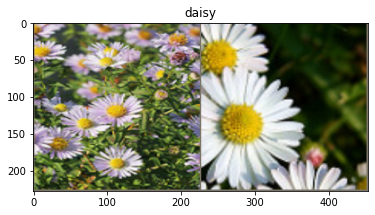

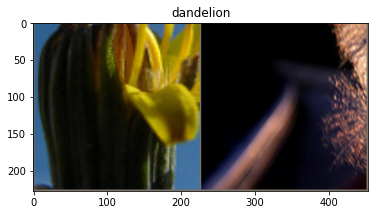

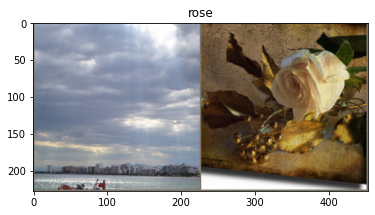

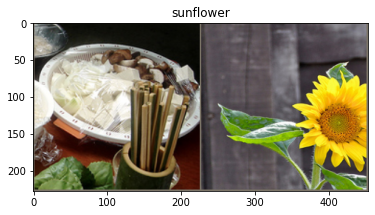

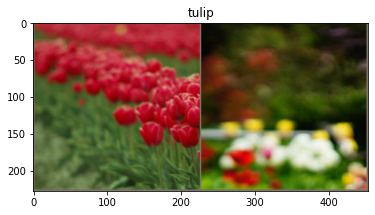

In [14]:
from torchvision.utils import make_grid

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

inputs, classes = next(iter(train_dataloader))

image_class_cnts = [0,0,0,0,0]
plot_images = [[],[],[],[],[]]
for i, c in zip(inputs, classes):
  if image_class_cnts[c] < 2:
    plot_images[c].append(i)
  image_class_cnts[c] += 1

for i, img in enumerate(plot_images):
  out = make_grid(img)
  imshow(out, title=class_names[i])




In [15]:
from torch.autograd import Function

class myReLU(nn.Module):
  def __init__(self):
      super(myReLU, self).__init__()

  def forward(self, input):
      output = input.clamp(min=0)
      return output

In [17]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()


        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            # nn.ReLU(),
            myReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        # self.relu = nn.ReLU()
        self.af = myReLU()


        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        # x = self.relu(x)
        x = self.af(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            # nn.ReLU(),
            myReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            # nn.ReLU(),
            myReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        # self.relu = nn.ReLU()
        self.af = myReLU()


        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        # x = self.relu(x)
        x = self.af(x)
        return x

In [18]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=5, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            # nn.ReLU(),
            myReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [19]:
# class myOjigoJirineunNetwork(nn.Module):
#     def __init__(self):
#         super(myOjigoJirineunNetwork, self).__init__()
#         self.flatten = nn.Flatten()
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(224*224*3, 512), # 28x28: FansionMNIST HxW
#             nn.ReLU(),
#             nn.Linear(512, 512),
#             nn.ReLU(),
#             nn.Linear(512, 5),
#         )

#     def forward(self, x):
#         x = self.flatten(x)
#         logits = self.linear_relu_stack(x)
#         return logits

In [20]:
learning_rate = 1e-3
batch_size = 16
epochs = 5

In [21]:
# def train_loop(dataloader, model, loss_fn, optimizer):
#     size = len(dataloader.dataset)
#     for batch, (X, y) in enumerate(dataloader):
#         # Compute prediction and loss
#         pred = model(X)
#         loss = loss_fn(pred, y)

#         # Backpropagation
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if batch % 100 == 0:
#             loss, current = loss.item(), batch * len(X)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


# def test_loop(dataloader, model, loss_fn):
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     test_loss, correct = 0, 0

#     with torch.no_grad():
#         for X, y in dataloader:
#             pred = model(X)
#             test_loss += loss_fn(pred, y).item()
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()

#     test_loss /= num_batches
#     correct /= size
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [22]:
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train_loop(train_dataloader, model, loss_fn, optimizer)
#     test_loop(val_dataloader, model, loss_fn)
# print("Done!")

In [23]:
model = resnet18().to(device)

In [24]:
# Initialize the loss function
# model = myOjigoJirineunNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [25]:
import copy
import time
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [26]:
import torch.optim as optim
from torch.optim import lr_scheduler

model_ft = resnet18()
num_ftrs = model_ft.fc.in_features
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [27]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3911 Acc: 0.3972
val Loss: 1.2573 Acc: 0.4844

Epoch 1/24
----------
train Loss: 1.1829 Acc: 0.5296
val Loss: 1.1732 Acc: 0.5428

Epoch 2/24
----------
train Loss: 1.1025 Acc: 0.5580
val Loss: 0.9572 Acc: 0.6152

Epoch 3/24
----------
train Loss: 1.0637 Acc: 0.5740
val Loss: 0.8662 Acc: 0.6572

Epoch 4/24
----------
train Loss: 1.0331 Acc: 0.6028
val Loss: 1.0577 Acc: 0.5888

Epoch 5/24
----------
train Loss: 1.0168 Acc: 0.5916
val Loss: 0.7643 Acc: 0.7080

Epoch 6/24
----------
train Loss: 0.9715 Acc: 0.6256
val Loss: 0.8303 Acc: 0.6848

Epoch 7/24
----------
train Loss: 0.8698 Acc: 0.6720
val Loss: 0.6913 Acc: 0.7368

Epoch 8/24
----------
train Loss: 0.8362 Acc: 0.6856
val Loss: 0.6635 Acc: 0.7660

Epoch 9/24
----------
train Loss: 0.8388 Acc: 0.6812
val Loss: 0.6591 Acc: 0.7520

Epoch 10/24
----------
train Loss: 0.7936 Acc: 0.7040
val Loss: 0.6388 Acc: 0.7672

Epoch 11/24
----------
train Loss: 0.8345 Acc: 0.6864
val Loss: 0.6380 Acc: 0.7716

Ep

In [28]:
pytorch_total_params = sum(p.numel() for p in model_ft.parameters())
pytorch_total_params

11179077

In [29]:
def eval_model(model, test_data, criterion):
    since = time.time()

    # best_model_wts = copy.deepcopy(model.state_dict())
    # best_acc = 0.0

    # Each epoch has a training and validation phase
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        print("pred")
        print(preds)
        print("test")
        print(labels.data)
        print(len(labels.data))

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / test_dataset_size
    epoch_acc = running_corrects.double() / test_dataset_size

    print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return

In [30]:
eval_model(model_ft, test_dataloader, criterion)

pred
tensor([4, 4, 0, 1, 0, 0, 0, 4, 4, 2, 0, 4, 1, 3, 2, 3], device='cuda:0')
test
tensor([2, 4, 0, 4, 0, 2, 0, 4, 2, 2, 0, 4, 1, 1, 2, 3], device='cuda:0')
16
pred
tensor([0, 3, 3, 3, 3, 4, 3, 1, 2, 1, 4, 3, 0, 1, 3, 4], device='cuda:0')
test
tensor([0, 3, 3, 3, 3, 2, 3, 1, 2, 4, 2, 3, 0, 1, 3, 4], device='cuda:0')
16
pred
tensor([1, 1, 1, 1, 0, 0, 1, 3, 3, 2, 0, 3, 1, 1, 0, 3], device='cuda:0')
test
tensor([1, 1, 1, 1, 2, 0, 1, 3, 3, 4, 2, 3, 1, 2, 0, 3], device='cuda:0')
16
pred
tensor([4, 4, 0, 2, 2, 4, 0, 2, 0, 4, 2, 1, 3, 1, 2, 3], device='cuda:0')
test
tensor([4, 2, 1, 2, 2, 4, 1, 2, 0, 2, 0, 1, 4, 1, 2, 3], device='cuda:0')
16
pred
tensor([4, 2, 1, 4, 0, 0, 1, 0, 2, 3, 1, 4, 3, 4, 3, 3], device='cuda:0')
test
tensor([2, 2, 1, 4, 1, 0, 1, 0, 4, 3, 1, 4, 3, 4, 2, 3], device='cuda:0')
16
pred
tensor([3, 2, 3, 2, 4, 4, 0, 3, 4, 1, 4, 4, 1, 0, 0, 3], device='cuda:0')
test
tensor([3, 2, 3, 2, 4, 4, 2, 3, 2, 1, 4, 4, 2, 0, 3, 0], device='cuda:0')
16
pred
tensor([0, 4, 4, 4, 4, 3, 2, 